In [1]:
from q_lab_toolbox.unitary_circuits import Qubit, HalfTriangularLayout, FullTriangularLayout, GateOperation, GateBasedUnitaryCircuit, RZ, RX, RydEnt
import matplotlib.pyplot as plt

In [2]:
triangleh = HalfTriangularLayout(3)
trianglef = FullTriangularLayout(3)

<Axes: title={'center': 'Qubit layout'}>

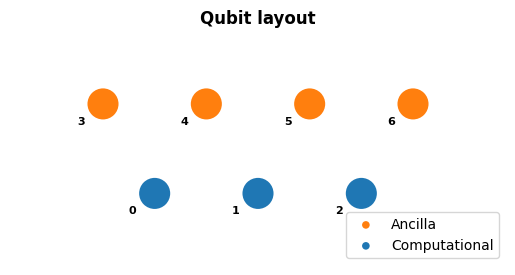

In [3]:
triangleh.show_layout()

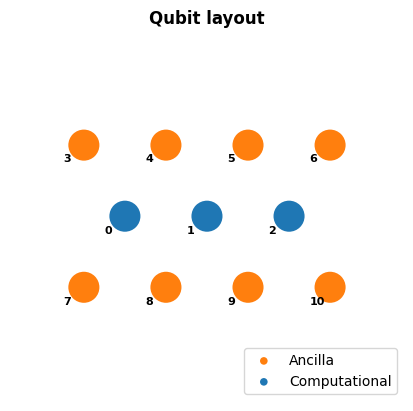

In [4]:
trianglef.show_layout()
plt.savefig("test.pdf")

In [5]:
print(trianglef)

full triangular qubit layout


In [6]:
triangle = HalfTriangularLayout(m=2)

operations = (
    GateOperation("AB", RZ()),
    GateOperation("AB", RX()),
    GateOperation("AB", RZ()),
    GateOperation("AB", RydEnt()),
)

HEA = GateBasedUnitaryCircuit(triangle, operations, D=3, repeats=1)

In [7]:
HEA

Gate based unitary circuit on half triangular qubit layout 
Gate operations: 
 [RZ gates, RX gates, RZ gates, rydberg entanglement] 
repeats: 1, D: 3

In [8]:
from q_lab_toolbox.optimizer import optimize
from q_lab_toolbox.training_data import RandomTrainingData, mk_training_data
from q_lab_toolbox.target_systems import DecaySystem
from q_lab_toolbox.initial_states import RhoRandHaar
from q_lab_toolbox.integration import BasicLinspace
from q_lab_toolbox.training_data import RandomTrainingData
from q_lab_toolbox.readout_operators import OrdernObservables, create_observables

In [9]:
target_system = DecaySystem(ryd_interaction=0.2, omegas=(0.5,0.3), m=2, gammas=(0.35,0.7))

rho0 = RhoRandHaar(m=2, seed=42)

integration = BasicLinspace(t_max=10, n_steps=1000)

Os = OrdernObservables(2, 2)

training_data = RandomTrainingData(
    target_system=target_system, N=2, delta_t=0.1, seed=42, L=10, Os=Os
)

import numpy as np

ts, Ess, Os = mk_training_data(training_data)
training_data.rho0s = np.array(training_data.rho0s)
training_data.Ess = Ess
training_data.Os = Os

In [10]:
optimize(HEA, training_data, max_count=10, n_grad=5)

c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_lab_toolbox\optimizer.py:62: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "J" failed type inference due to: non-precise type pyobject
During: typing of argument at c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_lab_toolbox\optimizer.py (66)

File "q_lab_toolbox\optimizer.py", line 66:
    def J(theta: Theta) -> float:
        <source elided>
        rhohatss = np.zeros((L, N + 1, dims_A, dims_A), dtype=np.complex128)
        for l in prange(L):
        ^

  @jit(forceobj=True, parallel=True)
c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_lab_toolbox\optimizer.py:51: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "N_step_evolver" failed type inference due to: non-precise type pyobject
During: typing of argument at c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_lab_toolbox\optimizer

(72.03335583602555-1.4952342944495018e-16j) (72.03335583602555-1.4952342944495018e-16j)


c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_lab_toolbox\optimizer.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
  grad = gradient(theta)


(72.03335583602555-1.4952342944495018e-16j) (72.03335583602555-1.4952342944495018e-16j)
(72.03335583602555-1.4952342944495018e-16j) (72.03335583602555-1.4952342944495018e-16j)
(72.03335583602555-1.4952342944495018e-16j) (72.03335583602555-1.4952342944495018e-16j)
(72.03335583602555-1.4952342944495018e-16j) (72.03335583602555-1.4952342944495018e-16j)


c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_lab_toolbox\optimizer.py:113: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i] = error


small sigma
Iteration: 0 
            Current gradient term: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
            Current error: 72.03335583602555 
            Current sigma values: (1, 0, 10)
Zero gradient hit after 0 iterations


(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([], dtype=float64),
 array([], shape=(0, 48), dtype=float64))